In [59]:
%load_ext autoreload
%autoreload 2

from biolearn.data_library import DataLibrary
import pickle
from tqdm import tqdm
import textwrap
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, wilcoxon
from statsmodels.stats.multitest import multipletests
from os.path import basename, splitext, exists
from glob import glob

from computage.utils.data_utils import test_dataset
from computage.configs.datasets_bench_config import *
from computage.benchmarking.benchmarking import EpiClocksBenchmarking

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# test call of dataset

In [166]:
gse = 'GSE52588'
data_source = DataLibrary().get(gse)

print(textwrap.fill(data_source.summary, 70))
data=data_source.load()

Down syndrome is characterized by a wide spectrum of clinical signs,
which include cognitive and endocrine disorders and haematological
abnormalities. Although it is well established that the causative
defect of Down syndrome is the trisomy of chromosome 21, the molecular
bases of Down syndrome phenotype are still largely unknown. We used
the Infinium HumanMethylation450 BeadChip to investigate DNA
methylation patterns in whole blood from 29 subjects affected by Down
syndrome (DS), using their healthy relatives as controls (mothers  and
unaffected siblings). This family-based model allowed us to monitor
possible confounding effects on DNA methylation patterns deriving from
genetic and environmental (lifestyle) factors. The identified
epigenetic signature of Down syndrome includes differentially
methylated regions that, although enriched on chromosome 21, interest
most of the other chromosomes and can be functionally linked to the
developmental and haematological defects characteristic 

In [167]:
data_obj = {}
data_obj['data'] = data.dnam
data_obj['meta'] = data.metadata

In [168]:
pickle.dump(data_obj, open(f'data/{gse}.pkl', 'wb'))

In [169]:
#now load it
data_obj = pickle.load(open(f'data/{gse}.pkl', 'rb'))

In [171]:
data_obj['meta']['disease_state']#.value_counts()

id
GSM1272122    Down syndrome
GSM1272123    Down syndrome
GSM1272124    Down syndrome
GSM1272125    Down syndrome
GSM1272126    Down syndrome
                  ...      
GSM1272204          healthy
GSM1272205          healthy
GSM1272206          healthy
GSM1272207          healthy
GSM1272208          healthy
Name: disease_state, Length: 87, dtype: object

# Benchmarking of published clocks

In [72]:
models_config = {
    "in_library":{
        'Horvathv1':{},
        'Hannum':{},
        'Lin':{},
        'PhenoAge':{},
        'YingCausAge':{},
        'YingDamAge':{},
        'YingAdaptAge':{},
        'Horvathv2':{},
        'PEDBE':{},
        'HRSInCHPhenoAge':{},
    },
    #each model should have `path` in its dict values (see example)
    #each model should be stored in pickle (.pkl) format
    "new_models":{
        #'my_new_model_name': {'path':/path/to/model.pkl}
        
    }
}

datasets_config_short = dict(list(datasets_config.items())[:2])

In [71]:
bench = EpiClocksBenchmarking(
    models_config=models_config,
    datasets_config=datasets_config_short,
    experiment_prefix='test',
    correction_threshold=0.05,
    save_results=True,
    output_folder='./tmp_bench_results',
    verbose=1
)
bench.run()

10 models will be tested on 2 datasets.


Datasets:  50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

DS:GSE52588 - AAP testing 29 disease versus 58 healthy samples


Datasets: 100%|██████████| 2/2 [00:14<00:00,  7.07s/it]

Rheumatoid arthritis:GSE42861 - AAP testing 354 disease versus 335 healthy samples


In [5]:
# dnam, meta = pd.read_pickle(f'{PREFIX}GSE87648.pkl.gz', compression='gzip').values()

In [204]:
listmodels = glob('/tank/projects/computage/checkpoints/pls*pheno*ultra*')
listmodels, len(listmodels)

(['/tank/projects/computage/checkpoints/pls1_11_pheno_ultrav1.pkl',
  '/tank/projects/computage/checkpoints/pls1_7_kdm_pheno_ultrav1.pkl',
  '/tank/projects/computage/checkpoints/pls1_6_pheno_ultrav1.pkl',
  '/tank/projects/computage/checkpoints/pls1_1_kdm_pheno_ultrav1.pkl',
  '/tank/projects/computage/checkpoints/pls1_12_kdm_pheno_ultrav1.pkl',
  '/tank/projects/computage/checkpoints/pls1_6_kdm_pheno_ultrav1.pkl',
  '/tank/projects/computage/checkpoints/pls1_7_pheno_ultrav1.pkl',
  '/tank/projects/computage/checkpoints/pls1_13_kdm_pheno_ultrav1.pkl',
  '/tank/projects/computage/checkpoints/pls1_10_pheno_ultrav1.pkl',
  '/tank/projects/computage/checkpoints/pls1_1_pheno_ultrav1.pkl',
  '/tank/projects/computage/checkpoints/pls1_4_pheno_ultrav1.pkl',
  '/tank/projects/computage/checkpoints/pls1_9_kdm_pheno_ultrav1.pkl',
  '/tank/projects/computage/checkpoints/pls1_13_pheno_ultrav1.pkl',
  '/tank/projects/computage/checkpoints/pls1_3_kdm_pheno_ultrav1.pkl',
  '/tank/projects/computage/c

In [206]:
from biolearn.data_library import GeoData
from biolearn.model_gallery import ModelGallery

published = False

gallery = ModelGallery()

bench_results_AAP = pd.DataFrame()
bench_results_AA0 = pd.DataFrame()
datasets_predictions = {}
for gse, conf in datasets_config.items():
    #import data
    path, cond, test = conf.values()
    dnam, meta = pd.read_pickle(path, compression='gzip').values()
    data = GeoData(meta, dnam.T)

    ###Predict datasets and gather predictions
    #Note that by default clocks will impute missing data.
    #To change this behavior set the imputation= parameter when getting the clock #???

    predictions = {}
    if published:
        #published clocks prediction
        keys = list(gallery.model_definitions.keys())
        for k in tqdm(keys):
            try:
                if gallery.model_definitions[k]['output']=='Age (Years)':
                    results = gallery.get(k, imputation_method='none').predict(data)
                    predictions[k] = results['Predicted']
            except:
                print('Oops!')
                continue
    else:
        #de novo clocks prediction
        for path in tqdm(listmodels):
            k = splitext(basename(path))[0]
            model = pickle.load(open(path, 'rb'))
            try:
                dnam_ = dnam.reindex(columns = list(model.pls.feature_names_in_)).copy()
            except:
                dnam_ = dnam.reindex(columns = list(model.feature_names_in_)).copy()
                dnam_ = dnam_.fillna(0.)
            
            preds_ = model.predict(dnam_)
            if type(preds_) == np.ndarray:
                predictions[k] = pd.Series(preds_, index=dnam.index)
            else:
                predictions[k] = pd.Series(preds_.values, index=dnam.index)
        
    pred = pd.DataFrame(predictions)
    datasets_predictions[gse] = pred.copy()
    #meta filtering
    no_age_na_indices = meta[~meta['Age'].isna()].index
    meta = meta.loc[no_age_na_indices]
    if test == 'AAP':
        #calculating mann-whitney test for difference in age acceleration between disease and healthy cohorts
        disease_idx = meta.index[meta['Condition'] == cond]
        healthy_idx = meta.index[meta['Condition'] == 'HC']
        print(f'{cond}:{gse} - AAP testing {len(disease_idx)} disease versus {len(healthy_idx)} healthy samples')
        pvals = {}
        for col in pred.columns:
            disease_true = meta.loc[disease_idx, 'Age'].values
            healthy_true = meta.loc[healthy_idx, 'Age'].values
            disease_pred = pred.loc[disease_idx, col].values
            healthy_pred = pred.loc[healthy_idx, col].values
            disease_delta = disease_pred - disease_true
            healthy_delta = healthy_pred - healthy_true
            stat, pval = mannwhitneyu(disease_delta, healthy_delta, alternative='greater')
            pvals[col] = pval
        bench_results_AAP[f'{cond}:{gse}:AAP'] = pd.Series(pvals)
    elif test == 'AA0':
        #calculating wilcoxon test for positive age (>0) acceleration in disease cohort
        disease_idx = meta.index[meta['Condition'] == cond]
        print(f'{cond}:{gse} - AA0 testing {len(disease_idx)} disease samples')
        pvals = {}
        for col in pred.columns:
            disease_true = meta.loc[disease_idx, 'Age'].values
            disease_pred = pred.loc[disease_idx, col].values
            disease_delta = disease_pred - disease_true
            stat, pval = wilcoxon(disease_delta, alternative='greater')
            pvals[col] = pval
        bench_results_AA0[f'{cond}:{gse}:AA0'] = pd.Series(pvals)
    else:
        NotImplementedError("Only two tests are currently available: ['AAP', 'AA0'].")
    

100%|██████████| 26/26 [00:01<00:00, 14.64it/s]


DS:GSE52588 - AAP testing 29 disease versus 58 healthy samples


100%|██████████| 26/26 [00:02<00:00, 10.46it/s]


Rheumatoid arthritis:GSE42861 - AAP testing 354 disease versus 335 healthy samples


100%|██████████| 26/26 [00:00<00:00, 26.78it/s]


AD:GSE59685 - AAP testing 287 disease versus 103 healthy samples


100%|██████████| 26/26 [00:11<00:00,  2.30it/s]


AD:GSE80970 - AAP testing 148 disease versus 138 healthy samples


100%|██████████| 26/26 [00:00<00:00, 52.14it/s]


IBD:GSE87640 - AAP testing 156 disease versus 84 healthy samples


100%|██████████| 26/26 [00:27<00:00,  1.07s/it]


IBD:GSE87648 - AAP testing 204 disease versus 178 healthy samples


100%|██████████| 26/26 [00:00<00:00, 54.70it/s]


IBD:GSE32148 - AAP testing 27 disease versus 19 healthy samples


100%|██████████| 26/26 [00:01<00:00, 22.59it/s]


HIV:GSE53840 - AA0 testing 111 disease samples


100%|██████████| 26/26 [02:17<00:00,  5.29s/it]


HT:GSE157131 - AAP testing 146 disease versus 1072 healthy samples


100%|██████████| 26/26 [00:00<00:00, 67.53it/s]


PAH:GSE84395 - AAP testing 21 disease versus 16 healthy samples


100%|██████████| 26/26 [00:01<00:00, 25.10it/s]


AS:GSE56046 - AAP testing 776 disease versus 339 healthy samples


100%|██████████| 26/26 [00:00<00:00, 28.75it/s]


AS:GSE56581 - AAP testing 776 disease versus 339 healthy samples


100%|██████████| 26/26 [00:02<00:00, 11.46it/s]


AS:GSE107143 - AAP testing 8 disease versus 8 healthy samples


100%|██████████| 26/26 [00:02<00:00,  9.45it/s]


IHD:GSE62867 - AA0 testing 24 disease samples


100%|██████████| 26/26 [00:05<00:00,  5.10it/s]


CVA:GSE69138 - AA0 testing 185 disease samples


100%|██████████| 26/26 [00:03<00:00,  8.61it/s]


CVA:GSE203399 - AA0 testing 121 disease samples


100%|██████████| 26/26 [00:02<00:00, 11.70it/s]


HF:GSE109096 - AA0 testing 11 disease samples


100%|██████████| 26/26 [00:02<00:00, 10.43it/s]


HF:GSE197670 - AA0 testing 44 disease samples


100%|██████████| 26/26 [00:00<00:00, 58.79it/s]


AS:GSE46394 - AAP testing 34 disease versus 15 healthy samples


100%|██████████| 26/26 [00:02<00:00,  9.77it/s]


T2D:GSE38291 - AAP testing 15 disease versus 15 healthy samples


100%|██████████| 26/26 [00:08<00:00,  2.93it/s]


OBS:GSE49909 - AAP testing 31 disease versus 80 healthy samples


100%|██████████| 26/26 [00:00<00:00, 76.88it/s]


OBS:GSE50498 - AAP testing 7 disease versus 41 healthy samples


100%|██████████| 26/26 [00:13<00:00,  1.96it/s]


OBS:GSE73103 - AAP testing 17 disease versus 338 healthy samples


100%|██████████| 26/26 [00:03<00:00,  6.82it/s]


OBS:GSE222595 - AAP testing 96 disease versus 96 healthy samples


100%|██████████| 26/26 [00:00<00:00, 37.22it/s]


OBS:GSE48325 - AAP testing 37 disease versus 18 healthy samples


100%|██████████| 26/26 [00:00<00:00, 40.02it/s]


OBS:GSE61256 - AAP testing 37 disease versus 18 healthy samples


100%|██████████| 26/26 [00:00<00:00, 63.33it/s]


T2D:GSE62003 - AA0 testing 58 disease samples


In [167]:
#dnam, meta = pd.read_pickle(datasets_config['GSE53840']['path'], compression='gzip').values()

In [207]:
def correction(x):
    return multipletests(x, method='fdr_bh')[1]

bench_results = pd.concat([bench_results_AAP, bench_results_AA0], axis=1).dropna(axis=0)
corrected_results_AAP = bench_results_AAP.T.apply(correction, axis=0).T < 0.05
corrected_results_AA0 = bench_results_AA0.T.apply(correction, axis=0).T < 0.05
corrected_results = pd.concat([corrected_results_AAP, corrected_results_AA0], axis=1)

print(corrected_results.shape)
corrected_results.sum(axis=1).sort_values(ascending=False)

(26, 27)


pls1_4_kdm_pheno_ultrav1     11
pls1_4_pheno_ultrav1         11
pls1_3_kdm_pheno_ultrav1     10
pls1_5_kdm_pheno_ultrav1     10
pls1_3_pheno_ultrav1         10
pls1_11_kdm_pheno_ultrav1    10
pls1_6_kdm_pheno_ultrav1      9
pls1_13_kdm_pheno_ultrav1     9
pls1_12_kdm_pheno_ultrav1     9
pls1_1_kdm_pheno_ultrav1      9
pls1_2_kdm_pheno_ultrav1      9
pls1_5_pheno_ultrav1          9
pls1_8_kdm_pheno_ultrav1      9
pls1_10_kdm_pheno_ultrav1     9
pls1_11_pheno_ultrav1         8
pls1_7_kdm_pheno_ultrav1      8
pls1_9_kdm_pheno_ultrav1      8
pls1_10_pheno_ultrav1         8
pls1_2_pheno_ultrav1          8
pls1_12_pheno_ultrav1         7
pls1_6_pheno_ultrav1          7
pls1_1_pheno_ultrav1          7
pls1_13_pheno_ultrav1         7
pls1_7_pheno_ultrav1          6
pls1_9_pheno_ultrav1          6
pls1_8_pheno_ultrav1          6
dtype: int64

In [208]:
bench_results.to_csv('/tank/projects/computage/results/bench_results_pls_pheno_ultra.csv')
corrected_results.to_csv('/tank/projects/computage/results/bench_results_pls_pheno_ultra.csv')

In [15]:
pd.read_csv('/tank/projects/computage/results/bench_results_pre_noimputation_corrected.csv', index_col=0)#.sum(axis=1).sort_values(ascending=False)

,DS:GSE52588,Rheumatoid arthritis:GSE42861,AD:GSE59685,AD:GSE80970,Overweight:GSE73103,IBD:GSE87640,IBD:GSE87648,HT:GSE157131
Horvathv1,True,False,False,False,False,False,False,False
Hannum,True,True,False,False,False,True,True,False
Lin,True,False,False,False,False,True,False,False
PhenoAge,True,True,False,False,False,True,True,True
YingCausAge,True,False,False,False,False,False,False,False
YingDamAge,False,False,False,False,False,False,True,False
YingAdaptAge,True,False,False,False,False,False,False,False
Horvathv2,True,False,False,False,False,False,False,False
PEDBE,True,False,False,False,False,False,False,False
HRSInCHPhenoAge,True,True,False,False,True,True,True,True


In [13]:
pd.read_csv('/tank/projects/computage/results/bench_results_ultrav1_train_pheno_corrected.csv', index_col=0)#.sum(axis=1).sort_values(ascending=False)

,DS:GSE52588,Rheumatoid arthritis:GSE42861,AD:GSE59685,AD:GSE80970,Overweight:GSE73103,IBD:GSE87640,IBD:GSE87648,HT:GSE157131
pls1_11_pheno_ultrav1,True,False,False,False,False,False,False,False
pls1_7_kdm_pheno_ultrav1,True,False,False,False,False,False,True,False
pls1_6_pheno_ultrav1,True,False,False,False,False,False,False,False
pls1_1_kdm_pheno_ultrav1,True,True,False,False,False,False,False,False
pls1_12_kdm_pheno_ultrav1,True,False,False,False,False,False,True,False
pls1_6_kdm_pheno_ultrav1,True,False,False,False,False,False,True,False
pls1_7_pheno_ultrav1,True,False,False,False,False,False,False,False
pls1_13_kdm_pheno_ultrav1,True,False,False,False,False,False,True,False
pls1_10_pheno_ultrav1,True,False,False,False,False,False,False,False
pls1_1_pheno_ultrav1,True,True,False,False,False,False,False,False


In [23]:
pd.read_csv('/tank/projects/computage/results/bench_results_kdm_corrected.csv', index_col=0)

,DS:GSE52588,Rheumatoid arthritis:GSE42861,AD:GSE59685,AD:GSE80970,Overweight:GSE73103,IBD:GSE87640,IBD:GSE87648,HT:GSE157131
kdm_rse_all_20k,True,True,False,False,False,False,True,False
kdm_rse_forward_20k,False,False,False,False,True,True,False,False


In [84]:
bench_results_logical = bench_results < 0.05
bench_results_logical

In [49]:
#look up at all models
pd.DataFrame(gallery.model_definitions).T

,year,species,tissue,source,output,model
Horvathv1,2013,Human,Multi-tissue,https://genomebiology.biomedcentral.com/articl...,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Ho..."
Hannum,2013,Human,Blood,https://www.sciencedirect.com/science/article/...,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Ha..."
Lin,2016,Human,Blood,https://www.aging-us.com/article/100908/text,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Li..."
PhenoAge,2018,Human,Blood,https://www.aging-us.com/article/101414/text,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Ph..."
YingCausAge,2022,Human,Blood,https://www.biorxiv.org/content/10.1101/2022.1...,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Yi..."
YingDamAge,2022,Human,Blood,https://www.biorxiv.org/content/10.1101/2022.1...,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Yi..."
YingAdaptAge,2022,Human,Blood,https://www.biorxiv.org/content/10.1101/2022.1...,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Yi..."
Horvathv2,2018,Human,Skin + blood,https://www.aging-us.com/article/101508/text,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Ho..."
PEDBE,2019,Human,Buccal,https://www.pnas.org/doi/10.1073/pnas.1820843116,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'PE..."
Zhang_10,2019,Human,Blood,https://www.nature.com/articles/ncomms14617,Mortality Risk,"{'type': 'LinearMethylationModel', 'file': 'Zh..."


In [50]:
import seaborn as sn
from matplotlib import pyplot as plt
import pandas as pd


plot_data = pd.DataFrame(predictions)
plot_data['Age'] = data.metadata['Age']
# plot_data['Disease'] = data.metadata['disease_state']
# disease_data = plot_data[plot_data['Disease'] == 'Down syndrome'].drop('Disease', axis=1) #schiszofrenia
# plot_data_melted = pd.melt(plot_data, id_vars=['Age', 'Disease'])

# sn.lmplot(data=plot_data_melted, x='Age', y='value', hue='variable');
# plt.axline([20, 20], [70, 70], ls='--', color='k')

In [51]:
plot_data

,Horvathv1,Hannum,Lin,PhenoAge,YingCausAge,YingDamAge,YingAdaptAge,Horvathv2,PEDBE,HRSInCHPhenoAge,Age
GSM1272122,29.876483,32.617185,31.411597,28.861048,16.895548,27.598242,32.286782,18.421467,9.078646,25.881562,18.0
GSM1272123,17.609619,26.582718,13.409489,21.317840,17.144923,27.806908,24.477187,13.541953,7.894768,16.450110,12.0
GSM1272124,18.878543,22.533819,15.420759,16.551206,17.863413,29.359306,20.724217,14.298157,6.817744,18.111427,13.0
GSM1272125,39.421562,40.391358,34.146930,36.086112,32.428994,56.867960,11.380066,28.425958,8.333164,31.510198,24.0
GSM1272126,47.817289,50.234423,44.455829,34.611126,43.526773,71.695487,18.656148,42.083480,9.517553,37.176587,33.0
...,...,...,...,...,...,...,...,...,...,...,...
GSM1272204,62.688654,65.235059,62.116400,56.385575,60.435429,80.888731,28.122310,64.153136,12.133594,56.922932,66.0
GSM1272205,71.560951,72.130206,54.213085,58.955558,69.240530,121.150573,13.182748,66.792292,13.677227,58.419500,60.0
GSM1272206,67.417340,70.033424,67.808868,58.020535,63.530617,87.793764,29.338242,64.512824,12.850942,61.575496,68.0
GSM1272207,49.178168,51.000206,44.120887,42.695101,47.389637,81.219681,2.483425,47.489709,11.091737,46.472745,48.0


In [55]:
from scipy.stats import mannwhitneyu
mannwhitneyu([10,12,9], [4,5,6,7,2,1,3], alternative='greater')

MannwhitneyuResult(statistic=21.0, pvalue=0.008333333333333333)

In [148]:
def single_dataset_benchmarking():
    pass
    

,Horvathv1,Hannum,Lin,PhenoAge,YingCausAge,YingDamAge,YingAdaptAge,Horvathv2,PEDBE,HRSInCHPhenoAge,Age
GSM1009660,30.452585,35.009794,22.481143,28.115610,30.434049,34.902735,31.086773,31.937480,9.311110,29.357422,32.0
GSM1009661,24.820739,25.911236,15.589432,19.577701,18.265357,47.760207,7.942192,25.658929,8.164568,14.805392,24.0
GSM1009662,65.401855,65.536941,50.431606,60.543320,52.875835,54.596133,48.858212,66.537082,15.503905,66.994001,65.0
GSM1009663,23.173561,15.512122,15.228030,11.743696,16.651125,40.692965,-8.574770,19.032609,6.310605,8.994985,25.0
GSM1009664,32.450846,31.191178,24.324188,27.496016,31.998270,62.761372,1.637749,27.045364,8.590446,30.087520,32.0
...,...,...,...,...,...,...,...,...,...,...,...
GSM1009740,31.631162,29.981612,31.311439,30.648356,22.990395,48.325120,11.879204,23.230279,8.318810,28.005342,26.0
GSM1009741,26.312627,23.818356,18.986301,15.770317,18.361857,17.301181,26.042993,21.748744,8.335067,13.413227,32.0
GSM1009890,25.879032,27.949780,28.400974,21.455877,22.560465,23.554604,19.955139,22.437033,8.139275,20.685244,27.0
GSM1009891,33.055429,28.057966,26.933006,20.018195,19.344812,37.818414,21.896244,27.015459,8.219594,28.613943,29.0


In [179]:
from scipy.stats import mannwhitneyu

y = disease_data['Age']
for c in disease_data.columns[:-1]:
    x = disease_data[c]
    # stat, pval = mannwhitneyu(x, y, alternative='greater') #has greater power than wilcoxon
    stat, pval = wilcoxon(x - y, alternative='greater')
    print(f'{c}, pval = {round(pval, 5)}')


Horvathv1, pval = 0.0
Hannum, pval = 0.0
Lin, pval = 0.0
PhenoAge, pval = 0.0
YingCausAge, pval = 0.0
YingDamAge, pval = 0.0
YingAdaptAge, pval = 1.0
Horvathv2, pval = 0.0
PEDBE, pval = 1.0
HRSInCHPhenoAge, pval = 0.00176


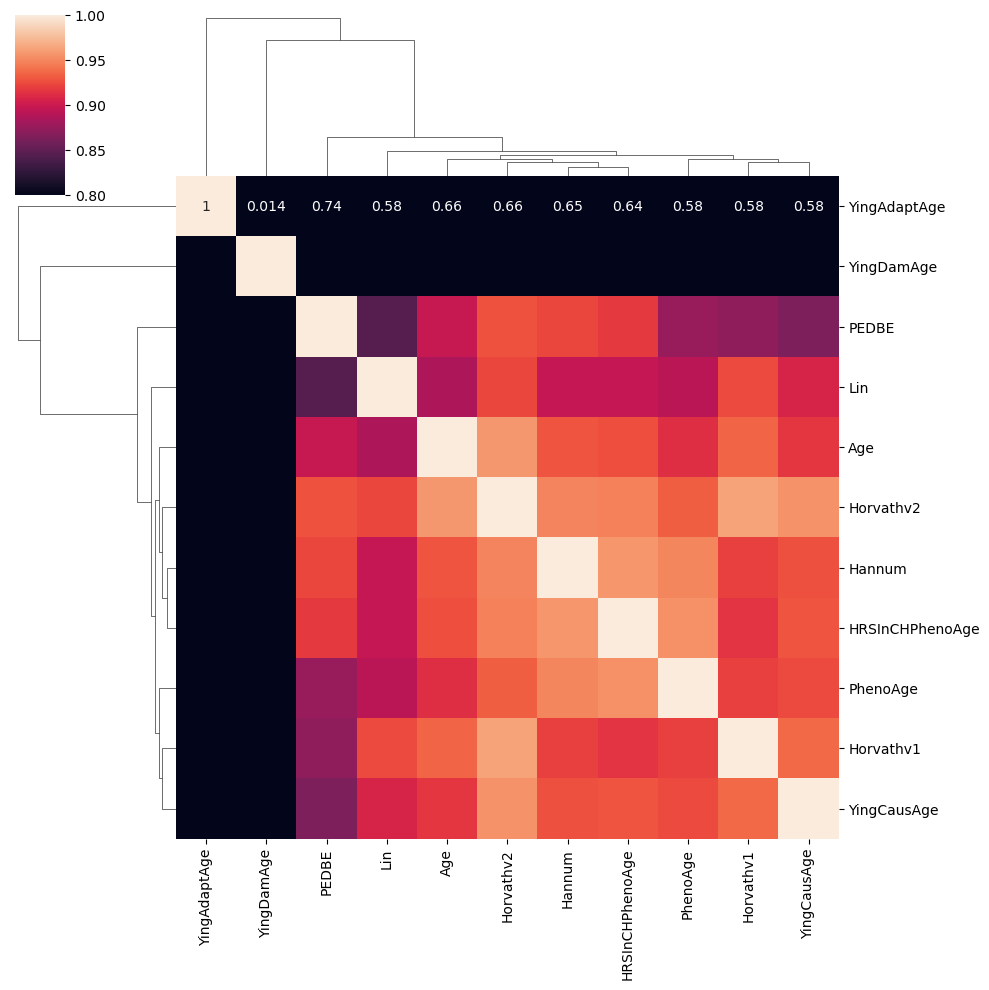

In [72]:
sn.clustermap(plot_data.corr(), annot=True, vmin=0.8)